# Is Perisher Full of Shit?
Do ski resorts artifically inflate their forecasts to increase business?

### Config 

In [3]:
%load_ext autoreload
%autoreload 2

# imports
import getPerisherForecast
import getTableauWrapper

import pandas as pd
import datetime
import os, sys
import sqlite3

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


# globals
db = "./catch.db"
conn = sqlite3.connect(db)

today = datetime.datetime.strftime(datetime.datetime.today(), '%Y-%m-%d')
print(f"\nLast run: {today}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Last run: 2020-10-10


### Get Perisher Forecast

In [4]:
perisherWrapper = getPerisherForecast.PerisherWrapper()
df_forecast = perisherWrapper.findPerisherForecast()
print(df_forecast.shape)
df_forecast

Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[2]/div[2]/section[1]/div/div[2]/div[7]/table/tbody/tr[13]/td[1]"}
  (Session info: chrome=85.0.4183.121)

Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[2]/div[2]/section[1]/div/div[2]/div[7]/table/tbody/tr[13]/td[2]"}
  (Session info: chrome=85.0.4183.121)

Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[2]/div[2]/section[1]/div/div[2]/div[7]/table/tbody/tr[13]/td[3]"}
  (Session info: chrome=85.0.4183.121)

Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[2]/div[2]/section[1]/div/div[2]/div[7]/table/tbody/tr[13]/td[4]"}
  (Session info: chrome=85.0.4183.121)

Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[2]/div[2]/section[1]/div/div[2]/div[7]/table/tbody/tr[13]/td[5]"}
  (Session info: chrome=8

,forecast_date,weather,prob._of_precip,likely_snow,snow_level,wind
0,Sat Oct 10,Mostly sunny. Possible late shower,45%,Nil,,NW
1,Sun Oct 11,Mostly cloudy. Showers later,55%,Nil,,W to SE
2,Mon Oct 12,Partly cloudy. Showers later,60%,Nil,,NW to SW
3,Tue Oct 13,Partly cloudy. Possible shower,60%,Nil,,SE to W
4,Wed Oct 14,Partly cloudy. Possible shower,70%,Nil,,NE/NW
5,Thu Oct 15,Mostly cloudy. Showers,70%,Nil,,NE to NW
6,Fri Oct 16,Mostly cloudy. Showers,60%,Nil,,NE to NW
7,Sat Oct 17,Mostly cloudy. Showers,60%,Nil,,N/NW
8,Sun Oct 18,Mostly cloudy. Showers,60%,Nil,,NE to NW
9,Mon Oct 19,Mostly cloudy. Showers,60%,Nil,,N to NW


### Parse Forecast

In [6]:

def days_from_actual(r):
    
    scrapped_date = datetime.datetime.strptime(r['scrapped_date'], '%Y-%m-%d')
    # forecast_date = datetime.datetime.strptime(r['forecast_date_parsed'], '%Y-%m-%d %H:%M:%S')
    # print(scrapped_date, forecast_date)

    z = (r['forecast_date_parsed'] - scrapped_date).total_seconds() / (60 * 60 * 24)
    return z

df_forecast['forecast_date_parsed'] = df_forecast['forecast_date'].apply(
    lambda x: datetime.datetime.strptime(x+', 2020', '%a %b %d, %Y') if pd.notnull(x) else x
)

df_forecast['likely_snow_discrete'] = df_forecast['likely_snow'].apply(
    perisherWrapper.parseSnowForecast
)

df_forecast['scrapped_date'] = today

df_forecast['forecast_date_ordinal'] = df_forecast['forecast_date'].apply(
    lambda x: x.split(" ")[0] if pd.notnull(x) else x
)
df_forecast['days_from_actual'] = df_forecast.apply(
    days_from_actual,
    axis=1
)

df_forecast.to_sql(
    'perisherForecast',
    conn,
    if_exists='append'
)

### Format for Tableau

In [7]:
df_all_forecasts = pd.read_sql(
    '''
    SELECT
        P.forecast_date, forecast_date_parsed, wind, 
        likely_snow_discrete, A.actual_snow_discrete,
        scrapped_date, days_from_actual, forecast_date_ordinal
    FROM perisherForecast P

    LEFT JOIN (
        SELECT DISTINCT forecast_date, likely_snow_discrete as actual_snow_discrete
        FROM perisherForecast
        WHERE days_from_actual = 0.0
    ) A ON
        P.forecast_date = A.forecast_date
    ''',
    conn
)

df_all_forecasts['likely_snow_discrete'] = df_all_forecasts['likely_snow_discrete'].apply(
    lambda x: float(x) if pd.notnull(x) else x
)

df_all_forecasts.drop_duplicates(inplace=True)
print(df_all_forecasts.shape)
df_all_forecasts.head()

(679, 8)


,forecast_date,forecast_date_parsed,wind,likely_snow_discrete,actual_snow_discrete,scrapped_date,days_from_actual,forecast_date_ordinal
0,Fri Aug 14,2020-08-14 00:00:00,NE,3.5,3.5,2020-08-14,0.0,Fri
1,Sat Aug 15,2020-08-15 00:00:00,SW,2.0,3.5,2020-08-14,1.0,Sat
2,Sun Aug 16,2020-08-16 00:00:00,SW/NW,3.5,3.5,2020-08-14,2.0,Sun
3,Mon Aug 17,2020-08-17 00:00:00,NW,2.0,2.0,2020-08-14,3.0,Mon
4,Tue Aug 18,2020-08-18 00:00:00,N,22.5,7.5,2020-08-14,4.0,Tue


In [8]:
# write to tableau specific format
getTableauWrapper.makeConversion(df_all_forecasts, "all_forecasts")
getTableauWrapper.cleanLogs()

processing table: 679it [00:00, 21919.48it/s]

Table 'Extract' does not exist in extract ./tableau/all_forecasts.hyper, creating.
PYTHON: 10/10/2020 13:26

PYTHON: Directory cleaned
PYTHON: 10/10/2020 13:26


### Vis for Simple Tracking

Text(0.5, 1.0, 'predicted snow fall')

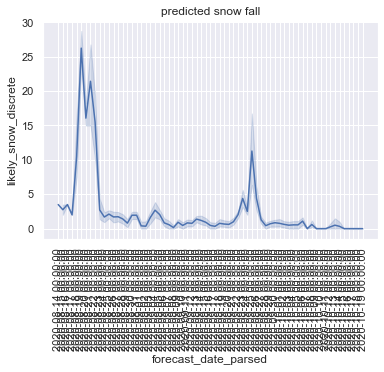

In [9]:
ax = sns.lineplot(x='forecast_date_parsed', y='likely_snow_discrete', data=df_all_forecasts)
plt.xticks(rotation=90)
plt.title('predicted snow fall')

In [10]:
fig = ax.get_figure()
fig.savefig("reports/perisherForecast.png")

### Export

In [11]:

df_all_forecasts.to_csv('./perisherDataExport.csv', index=False)